# Librairies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass
from typing import Tuple, List, Optional
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from tqdm import tqdm
from looping_model import *
import pyarrow as pa
import pyarrow.parquet as pq
from typing import Any, Tuple

# Values

In [3]:
# --- PARAMETER STRUCTURES --- #

@dataclass
class RunConfig:
    """Container for physical simulation parameters."""
    xmin: int
    xmax: int
    bps: int
    x_array: np.ndarray
    t_array: np.ndarray
    Pzero: np.ndarray
    ryu_bin: int
    ryu_x: np.ndarray
    ryu_y: np.ndarray
    folder_name: str = "probas_datas_opti"

@dataclass
class SimulationParams:
    """Container for run-specific configuration."""
    choice: str
    lp: float
    rcmin: float
    rcmax: float
    fnm: float
    width: float
    theta: float
    conv: float
    fbp: float

In [4]:
# Chromatin fiber
xmin = 1
xmax = 1_500
bps = 1
x_array = np.arange(xmin, xmax + bps, bps)
x_length = len(x_array)

# Times
t_array = np.logspace(start=1, stop=6, num=6, dtype=int)

# Parameters
choice_array = ["sphere", "camembert"]
lp_array = np.array([170])
rcmin_array = np.array([0])
rcmax_array = np.array([70, 140, 210, 280])
fnm_array = np.array([0, 0.2e-12, 0.3e-12, 0.4e-12, 0.5e-12, 0.6e-12, 0.7e-12, 1e-12])
width_array = np.array([1])
theta_array = np.array([np.pi])

# Conversion & Pzero
kb, T = 1.380649e-23, 300
bp_per_m_array = np.array([0.200e-9, 0.205e-9, 0.231e-9, 0.246e-9, 0.256e-9, 0.264e-9, 0.269e-9, 0.286e-9])
fbp_array = fnm_array / (kb * T) * bp_per_m_array
Pzero = np.array([1] + [0] * (x_length - 1))

# Env
os.chdir("/home/nicolas/Documents/Progs")
print("Parameters loaded.")

# Ryu
ryu_bin = 41
ryu_x = np.array([-0.,          40.6504065,   81.30081301, 121.95121951, 162.60162602,
                   203.25203252, 243.90243902, 284.55284553, 325.20325203, 365.85365854,
                   406.50406504, 447.15447154, 487.80487805, 528.45528455, 569.10569106])
ryu_y = np.array([0.00752587, 0.13076199, 0.22859831, 0.18438382, 0.11476952, 0.11288805,
                  0.08654751, 0.05268109, 0.02634055, 0.02163688, 0.01317027, 0.00752587,
                  0.0084666,  0.0028222,  0.00188147])

Parameters loaded.


# Functions

In [5]:
# --- CALCULATIONS --- #

def sum_by_shifted_chunks(data: np.ndarray, chunk_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """Sum array over shifted non-overlapping chunks."""
    indices = np.arange(chunk_size // 2, len(data), chunk_size)
    summed_values = np.add.reduceat(data, indices)
    summed_values /= np.sum(summed_values)
    centers = indices + (chunk_size // 2)
    centers[-1] = min(centers[-1], len(data) - 1)
    return centers, summed_values

def find_median(distribution: np.ndarray, values: np.ndarray) -> float:
    """Return the value corresponding to the 50% cumulative probability."""
    distribution /= np.sum(distribution)
    cumsum = np.cumsum(distribution)
    idx = np.searchsorted(cumsum, 0.5)
    return values[idx]


# --- PROBABILITIES  --- #

def calculate_probabilities(cfg: RunConfig, params: SimulationParams) -> Tuple[np.ndarray, np.ndarray]:
    """Compute Peq and P based on the selected configuration."""
    if params.choice == 'sphere':
        P, Peq = Pjump(
            lengths=cfg.x_array,
            time=cfg.t_array,
            P0=cfg.Pzero,
            lp=params.lp,
            Rc=params.rcmax,
            Rmin=params.rcmin,
            f=params.fbp
        )
    elif params.choice == 'camembert':
        P, Peq = Pjump_camembert(
            lengths=cfg.x_array,
            time=cfg.t_array,
            P0=cfg.Pzero,
            lp=params.lp,
            Rc=params.rcmax,
            Width=params.width,
            f=params.fbp,
            thetaf=params.theta
        )
    else:
        raise ValueError(f"Unknown choice: {params.choice}")

    P = np.transpose(P)
    return Peq, P

def run_single_proba(cfg: RunConfig, params: SimulationParams):
    """Run a single probability calculation and return results."""
    print(f"Running config: choice={params.choice}, lp={params.lp}, rcmin={params.rcmin}, rcmax={params.rcmax}bp, fnm={params.fnm:.2e}, theta={params.theta}")
    Peq, P = calculate_probabilities(cfg, params)
    P_points, Peq_summed = sum_by_shifted_chunks(Peq, cfg.ryu_bin)
    P_summed = [sum_by_shifted_chunks(P[i], cfg.ryu_bin)[1] for i in range(len(cfg.t_array))]
    medians = [find_median(P[i], cfg.x_array) for i in range(len(cfg.t_array))]
    return P_points, Peq, Peq_summed, P, P_summed, medians


# --- WRITING / READING --- #

def convert_to_serializable(value: Any) -> Any:
    """Convert NumPy types and arrays into serializable Python types."""
    if isinstance(value, np.generic):
        return value.item()
    elif isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        return [convert_to_serializable(v) for v in value]
    else:
        return value

def writing_parquet(filename: str, folder: str, data: dict) -> None:
    """ Write a dictionary to a compressed Parquet file using PyArrow. """
    out_path = os.path.join(folder, f"{filename}_{os.path.basename(folder)}.parquet")
    prepared_data = {
        k: [convert_to_serializable(v)] if not isinstance(v, list) else [convert_to_serializable(v)]
        for k, v in data.items()
    }
    try:
        table = pa.table(prepared_data)
        pq.write_table(table, out_path, compression='gzip')
    except Exception as e:
        print(f"[ERROR] Failed to write Parquet file: {e}")

def save_results(cfg: RunConfig, params: SimulationParams, results: Tuple):
    """Save results to disk as Parquet."""
    os.makedirs(cfg.folder_name, exist_ok=True)
    filename = f"{params.choice}_lp{params.lp}_rcmin{params.rcmin}_rcmax{params.rcmax}_Fnm{params.fnm}_Width{params.width}_Theta{params.theta}_conv{params.conv}"
    data = dict(zip(["P_points", "Peq", "Peq_summed", "P", "P_summed", "medians"], results))
    writing_parquet(filename, cfg.folder_name, data)

def read_results(cfg: RunConfig, params: SimulationParams) -> dict:
    """Load result from a saved Parquet file."""
    filename = f"{params.choice}_lp{params.lp}_rcmin{params.rcmin}_rcmax{params.rcmax}_Fnm{params.fnm}_Width{params.width}_Theta{params.theta}_conv{params.conv}"
    path = os.path.join(cfg.folder_name, f"{filename}_{os.path.basename(cfg.folder_name)}.parquet")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Missing result: {path}")
    df = pl.read_parquet(path)
    return {k: df[k].to_numpy()[0] for k in df.columns}


# --- WRAPPER / PLOTTING --- #

def full_run(cfg: RunConfig, params: SimulationParams):
    """Run one simulation and save results."""
    results = run_single_proba(cfg, params)
    save_results(cfg, params, results)
    return results

def plot_one(ax, cfg: RunConfig, params: SimulationParams, result_dict: dict, t_array: np.ndarray):
    """Plot Peq and P curves for one simulation on a matplotlib axis with plasma colormap."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_title(f"{params.choice}\nrcmax={params.rcmax}bp | F={params.fnm}pN")
    ax.plot(cfg.ryu_x, cfg.ryu_y, marker='o', label='Ryu data', ls='-', color='grey', markeredgecolor='black')
    ax.plot(cfg.x_array, result_dict["Peq"], marker='+', label='Peq', ls='--', c='k')
    # ax.plot(result_dict["P_points"], result_dict["Peq_summed"], marker='o', ls='-', label='Peq binned', c='r')

    cmap = plt.get_cmap('plasma')
    n_curves = len(t_array)
    colors = [cmap(i / (n_curves - 1)) for i in range(n_curves)]

    for i, P_t in enumerate(result_dict["P"]):
        color = colors[i]
        ax.plot(cfg.x_array, P_t, marker='+', label=f'P t={t_array[i]}', ls='--', color=color)
        # ax.plot(result_dict["P_points"], result_dict["P_summed"][i], marker='o', label=f'P_bin t={t_array[i]}', ls='-', color=color)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e0, 2 * cfg.xmax)
    ax.set_ylim(1e-15, 1e0)
    ax.legend(fontsize=7, loc='lower left')
    ax.grid(True, which='both')


# --- MULTI RUN & PLOT --- #

def run_multiple(cfg_template: RunConfig, param_grid: List[SimulationParams], t_array: np.ndarray, output_csv: str = "all_medians.csv"):
    """Run all parameter combinations and save results (no plots)."""
    rows = []
    header = ["choice", "rcmax", "fbp"] + [f"median_t{t}" for t in t_array]
    rows.append(header)

    pbar = tqdm(total=len(param_grid), desc="Running simulations")

    for params in param_grid:
        cfg = cfg_template
        results = full_run(cfg, params)
        save_results(cfg, params, results)

        result_dict = read_results(cfg, params)
        row_data = [params.choice, params.rcmax, params.fbp] + list(result_dict["medians"])
        rows.append(row_data)

        pbar.update(1)

    pbar.close()

    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(rows)

def plot_multiple(cfg_template: RunConfig, param_grid: List[SimulationParams], t_array: np.ndarray, output_fig: str = "all_probas_results.png"):
    """Reload results from disk and generate plots only."""
    nrows = len(set(p.rcmax for p in param_grid))
    ncols = len(set((p.fbp, p.choice) for p in param_grid))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = np.array(axes, dtype=object).reshape(nrows, ncols)

    pbar = tqdm(total=len(param_grid), desc="Plotting simulations")

    for idx, params in enumerate(param_grid):
        row, col = idx // ncols, idx % ncols
        cfg = cfg_template

        # Relire depuis disque
        result_dict = read_results(cfg, params)

        # Tracer sur l'axe
        ax = axes[row, col]
        plot_one(ax, cfg, params, result_dict, t_array)

        pbar.update(1)

    pbar.close()
    plt.tight_layout()
    plt.savefig(output_fig, dpi=300)

In [6]:
# One call parameters
lp = lp_array[0]
rcmin = rcmin_array[0]
rcmax = rcmax_array[2]
width = width_array[0]
theta = theta_array[0]

# Force selection
rank_test = 3
fnm = fnm_array[rank_test]
conv = bp_per_m_array[rank_test]
fbp = fbp_array[rank_test]
choice_test = choice_array[1]

# Run
cfg = RunConfig(
    xmin=xmin,
    xmax=xmax,
    bps=bps,
    x_array=x_array,
    t_array=t_array,
    Pzero=Pzero,
    ryu_bin=ryu_bin,
    ryu_x=ryu_x,
    ryu_y=ryu_y,
    folder_name="probas_datas_opti"
)

params = SimulationParams(
    choice=choice_test,
    lp=lp,
    rcmin=rcmin,
    rcmax=rcmax,
    fnm=fnm,
    width=width,
    theta=theta,
    conv=conv,
    fbp=fbp
)

results = full_run(cfg, params)
save_results(cfg, params, results)

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fnm=4.00e-13, theta=3.141592653589793


/home/nicolas/Documents/Progs/looping_model.py:118: RuntimeWarning: overflow encountered in multiply
  res = Jsyd(kappa) * A * B * C * Bessel0(D)
/home/nicolas/Documents/Progs/looping_model.py:106: RuntimeWarning: overflow encountered in exp
  B = np.exp(
/home/nicolas/Documents/Progs/looping_model.py:118: RuntimeWarning: overflow encountered in multiply
  res = Jsyd(kappa) * A * B * C * Bessel0(D)
/home/nicolas/Documents/Progs/looping_model.py:115: RuntimeWarning: overflow encountered in exp
  C = np.exp(-(d(kappa) * kappa * a * b * (1 + b) * r**2) / ((1 - b**2 * r**2) + EPS))
/home/nicolas/Documents/Progs/looping_model.py:315: RuntimeWarning: invalid value encountered in sqrt
  a = -rc * np.cos(theta) / np.sqrt(1 - rc**2 * np.sin(theta) ** 2) + 1
/home/nicolas/Documents/Progs/looping_model.py:115: RuntimeWarning: overflow encountered in exp
  C = np.exp(-(d(kappa) * kappa * a * b * (1 + b) * r**2) / ((1 - b**2 * r**2) + EPS))
/home/nicolas/Documents/Progs/looping_model.py:320: Runtim

Ready to plot for parameters:
  lp          = 170
  rcmin       = 0
  width       = 1
  theta       = 3.141592653589793
  rcmax       = 210
  fnm         = 4e-13
  conv        = 2.46e-10
  fbp         = 0.023756943292610938
  choice_test = camembert


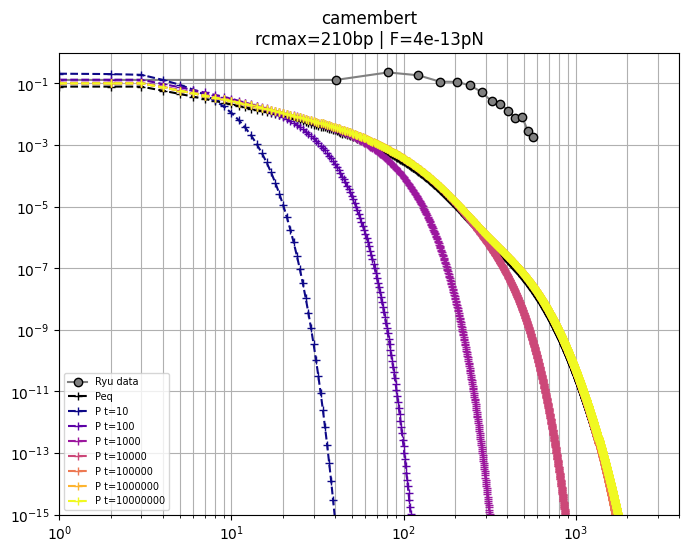

In [83]:
print("Ready to plot for parameters:")
print(f"  lp          = {lp}")
print(f"  rcmin       = {rcmin}")
print(f"  width       = {width}")
print(f"  theta       = {theta}")
print(f"  rcmax       = {rcmax}")
print(f"  fnm         = {fnm}")
print(f"  conv        = {conv}")
print(f"  fbp         = {fbp}")
print(f"  choice_test = {choice_test}")
plot_one(ax=None, cfg=cfg, params=params, result_dict=read_results(cfg=cfg, params=params), t_array=t_array)

In [ ]:
# 1. cfg_template
cfg_template = RunConfig(
    xmin=xmin,
    xmax=xmax,
    bps=bps,
    x_array=x_array,
    t_array=t_array,
    Pzero=np.zeros_like(x_array),
    ryu_bin=10,
    ryu_x=ryu_x,
    ryu_y=ryu_y
)

# 2. param_grid
param_grid = [
    SimulationParams(
        choice=choice,
        lp=lp,
        rcmin=rcmin,
        rcmax=rcmax,
        fnm=fnm,
        width=width,
        theta=theta,
        conv=conv,
        fbp=fbp
    )
    for choice in choice_array
    for lp in lp_array
    for rcmin in rcmin_array
    for rcmax in rcmax_array
    for fbp in fbp_array
]

# 3. run_multiple
run_multiple(cfg_template, param_grid, t_array)

Running simulations:   0%|          | 0/64 [00:00<?, ?it/s]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fnm=4.00e-13, theta=3.141592653589793


In [ ]:
plot_multiple(cfg_template, param_grid, t_array)

# #--- HEREEE ---#

In [14]:
def load_medians_csv(csv_path: str = "all_medians.csv") -> pd.DataFrame:
    """
    Load medians CSV as a pandas DataFrame.

    Returns:
        pd.DataFrame with columns: 'choice', 'rcmax', 'fbp', 'median_t1', ...
    """
    df = pl.read_csv(csv_path).to_pandas()
    print(f"Loaded {csv_path} with shape {df.shape}")
    return df

def filter_by_choice(df: pd.DataFrame, choice: str) -> pd.DataFrame:
    """Filter medians DataFrame for a specific simulation choice."""
    return df[df["choice"] == choice].copy()

def plot_medians_vs_time(
    df: pd.DataFrame,
    rcmax_array: np.ndarray,
    fnm_array: np.ndarray,
    t_array: np.ndarray,
):
    """
    Plot medians as a function of time (log-log) for each rcmax × fbp.
    """
    nrows, ncols = len(rcmax_array), len(fnm_array)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)

    for i, rc in enumerate(rcmax_array):
        for j, fnm in enumerate(fnm_array):
            ax = axes[i][j]
            row = df[(df["rcmax"] == rc) & (np.isclose(df["fbp"], fnm, atol=1e-6))]
            if row.empty:
                ax.set_visible(False)
                continue
            medians = row.iloc[0, 3:].values
            ax.plot(t_array, medians, marker='o', linestyle='-')
            ax.set_title(f'rc={rc} bp | F={fnm_array[j]:.1f} pN')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, which='both')
            ax.set_xlabel('Time (t)')
            ax.set_ylabel('Median (bp)')

    plt.tight_layout()
    plt.show()

def plot_medians_vs_force(
    df: pd.DataFrame,
    rcmax_array: np.ndarray,
    fnm_array: np.ndarray,
    t_array: np.ndarray,
    ryu_medians: np.ndarray = None
):
    """
    Plot median vs force for each time point, grouped by Rc.
    """
    fig, axes = plt.subplots(1, len(t_array), figsize=(5 * len(t_array), 4))
    if len(t_array) == 1:
        axes = [axes]

    for idx, t in enumerate(t_array):
        ax = axes[idx]
        for rc in rcmax_array:
            subset = df[df["rcmax"] == rc].sort_values("fnm")
            y = subset.iloc[:, 3 + idx].values
            if len(y) != len(fnm_array):
                continue
            ax.plot(fnm_array, y, marker='o', linestyle='--', label=f'rc={rc} bp')

        if ryu_medians is not None:
            ax.plot(fnm_array[1:], ryu_medians, marker='o', color='k', label='Ryu')

        ax.set_title(f't={t}')
        ax.set_xlabel("Force (N)")
        ax.set_ylabel("Median (bp)")
        ax.grid(True, which='both')
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_medians_vs_force_per_Rc(
    df: pd.DataFrame,
    rcmax_array: np.ndarray,
    fnm_array: np.ndarray,
    t_array: np.ndarray,
    ryu_medians: np.ndarray = None
):
    """
    Plot median vs force per rcmax, with one subplot per Rc and curves per t.
    """
    fig, axes = plt.subplots(1, len(rcmax_array), figsize=(5 * len(rcmax_array), 4))
    if len(rcmax_array) == 1:
        axes = [axes]

    for idx, rc in enumerate(rcmax_array):
        ax = axes[idx]
        subset = df[df["rcmax"] == rc].sort_values("fbp")
        if len(subset) != len(fnm_array):
            continue
        for i, t in enumerate(t_array):
            y = subset.iloc[:, 3 + i].values
            ax.plot(fnm_array, y, marker='o', linestyle='--', label=f't={t}')
        if ryu_medians is not None:
            ax.plot(fnm_array[1:], ryu_medians, marker='o', color='k', label='Ryu')

        ax.set_title(f'rc={rc}')
        ax.set_xlabel("Force (N)")
        ax.set_ylabel("Median (bp)")
        ax.grid(True, which='both')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
df = load_medians_csv("all_medians.csv")
df_choice = filter_by_choice(df, choice="camembert")

plot_medians_vs_time(df_choice, rcmax_array, fnm_array, t_array)
plot_medians_vs_force(df_choice, rcmax_array, fnm_array, t_array)
plot_medians_vs_force_per_Rc(df_choice, rcmax_array, fnm_array, t_array)


# Ryu here : integrate it in a signel file in order to just get the medians and the conversions

In [ ]:
# --- RYU CLEANED UTILITIES --- #

import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def convert_and_normalize(df: pl.DataFrame, conv: float = 0.246):
    """Convert nm to bp and normalize counts."""
    x_nm = df['Step size (nm)'].to_numpy()
    y_counts = df['Count'].to_numpy()
    x_bp = x_nm / conv
    y_probs = y_counts / np.sum(y_counts)
    return x_nm, x_bp, y_counts, y_probs

def truncate_positive_bp(x_bp: np.ndarray, y_prob: np.ndarray):
    """Keep only positive steps and renormalize."""
    mask = x_bp <= 0
    x = -x_bp[mask][::-1]
    y = y_prob[mask][::-1]
    return x, y / np.sum(y)

def plot_ryu_data(x_nm, x_bp, y_counts, y_probs, ryu_x, ryu_y):
    """Visualize original and truncated Ryu distributions."""
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    axs[0].plot(x_nm, y_counts, '+b'); axs[0].set_title("Counts (nm)")
    axs[1].plot(x_bp, y_probs, '+b'); axs[1].set_title("Proba (bp)")
    for ax in axs[2:]:
        ax.plot(ryu_x, ryu_y, 'ok'); ax.set_title("Truncated (>0) proba")
    axs[3].set_xscale("log"); axs[3].set_yscale("log")
    for ax in axs: ax.grid(True); ax.set_xlabel("Step (bp)")
    plt.suptitle("Ryu distributions"); plt.tight_layout(); plt.show()

def bin_width(ryu_x):
    """Return bin width from truncated x."""
    return int(np.round(np.diff(ryu_x)[0]))

# --- RYU MEDIAN UTILS --- #

def clean_ryu_sheet(df: pl.DataFrame, only_forward=True) -> pl.DataFrame:
    """Clean Ryu sheet and optionally flip negatives."""
    rename = {
        "__UNNAMED__0": "Step size (nm)", "Count": "F = 1 pN",
        "__UNNAMED__2": "F = 0.7 pN", "__UNNAMED__3": "F = 0.6 pN",
        "__UNNAMED__4": "F = 0.5 pN", "__UNNAMED__5": "F = 0.4 pN",
        "__UNNAMED__6": "F = 0.3 pN", "__UNNAMED__7": "F = 0.2 pN",
    }
    df = df.slice(1).rename(rename)
    df = df.with_columns([pl.col(c).cast(pl.Float64) for c in df.columns])
    order = ["Step size (nm)"] + sorted([c for c in df.columns if c != "Step size (nm)"])
    df = df.select(order)
    if only_forward:
        df = df.filter(pl.col("Step size (nm)") <= 0)
        df = df.with_columns(( -pl.col("Step size (nm)") ).alias("Step size (nm)"))
    return df

def extract_medians(df: pl.DataFrame, conv_map: dict) -> np.ndarray:
    """Extract and normalize medians from Ryu df."""
    x = df["Step size (nm)"].to_numpy()
    medians = []
    for col in df.columns[1:]:
        y = df[col].to_numpy()
        y /= np.sum(y)
        idx = np.searchsorted(np.cumsum(y), 0.5)
        medians.append(x[idx] / conv_map[col])
    return np.array(medians)

# --- MEDIANS CSV UTIL --- #

def read_medians_csv(path="all_medians.csv"):
    """Read medians CSV as Polars DataFrame."""
    try:
        df = pl.read_csv(path)
        pl.Config.set_tbl_cols(len(df.columns))
        print(f"CSV loaded: {path}")
        return df
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None



# Ligne 1 : données de la figure 3B (distribution)
df_force_3B = pl.read_excel("/home/nicolas/Documents/Progs/ryu_datas.xlsx", sheet_name="Fig. 3B")
x_nm, x_bp, y_counts, y_probs = convert_and_normalize(df_force_3B)
ryu_x, ryu_y = truncate_positive_bp(x_bp, y_probs)
plot_ryu_data(x_nm, x_bp, y_counts, y_probs, ryu_x, ryu_y)
ryu_bin = bin_width(ryu_x)
print(f"Bin width computed: {ryu_bin}")


# Ligne 2 : données de la figure 3E / S5B (médianes)
df_force_3E = pl.read_excel("/home/nicolas/Documents/Progs/ryu_datas.xlsx", sheet_name="Fig. 3E S5B")
df_cleaned = clean_ryu_sheet(df_force_3E, only_forward=True)

# Conversion pour chaque force (nm -> bp)
force_to_conv = {
    "F = 0.2 pN": 0.205,
    "F = 0.3 pN": 0.231,
    "F = 0.4 pN": 0.246,
    "F = 0.5 pN": 0.256,
    "F = 0.6 pN": 0.264,
    "F = 0.7 pN": 0.269,
    "F = 1 pN":   0.286,
}

medians_xlsx = extract_medians(df_cleaned, conv_map=force_to_conv)
print("\nExtracted medians from XLSX:\n", medians_xlsx)

# Optionnel : valeurs publiées dans l'article
ryu_medians = np.array([200, 170, 100, 130, 100, 90, 70])
print("\nPublished medians from paper:\n", ryu_medians)


# .